In [6]:
!pip install -q git+https://github.com/ficstamas/data-mining.git


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ipywidgets import interact, widgets

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Bruteforce

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

def similarity_brute_force(num_vectors=10_000, num_dimensions=300):
    X = np.random.rand(num_vectors, num_dimensions)
    q = np.random.rand(1, num_dimensions)
    
    # Brute force nearest neighbor
    sims = cosine_similarity(q, X)
    nn_index = np.argmax(sims)
    nn_index, sims[0, nn_index]

%timeit similarity_brute_force(1_000_000)

2.26 s ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


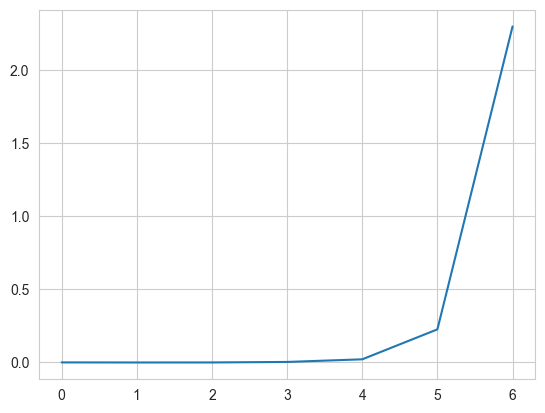

In [3]:
from time import perf_counter_ns

max_magnitude = 7
tm = []
x = [10**i for i in range(max_magnitude)]
for i in range(len(x)):
    repeated = []
    for _ in range(10):  # repeat 10 times to mitigate noise in runtime
        start = perf_counter_ns()
        similarity_brute_force(x[i])
        end = perf_counter_ns() - start
        repeated.append(end * 10**-9)
    tm.append(np.mean(repeated))
plt.plot(np.arange(max_magnitude), tm)

# Locality Sensitive Hashing (LSH)

Supposed we have $n$ elements in our dataset, finding the item which is the most similar to every item in the dataset takes $\binom{n}{2} = O(n^2)$ comparisons. For large values of $n$, this amount of comparison is definitely beyond what is practically manageable. For example:
- Google detects duplicate web pages out of billions.
- Spotify finds songs with similar acoustic fingerprints.
- Plagiarism detection tools spot near-duplicate essays.

These all require fast similarity search in huge, high-dimensional datasets.

**Hash functions**

An LSH scheme defines a family of hash functions $H$ such that
$$
\Pr_{h \sim H}[h(x) = h(y)] = \text{similarity}(x,y).
$$
Multiple hash functions are applied to each item to form a __signature vector__ (also called a sketch).

**Hash tables**

To amplify discrimination, we concatenate $k$ hash functions:
$$
g(x) = (h_1(x), h_2(x), \dots, h_k(x)).
$$
Each $g(x)$ serves as a key into a hash table. To increase recall, we build $L$ independent tables, each with its own $g$.

**Rows**

If we arrange all signatures into a matrix:
$$
\text{rows} \; \leftrightarrow \; \text{hash functions}, \quad
\text{columns} \; \leftrightarrow \; \text{items}.
$$
Each row corresponds to the output of one hash function across all items.

**Bands**

We split the signature matrix into $b$ bands, each containing $r$ rows, so that $br = \text{signature length}$.
Within a band, two items are placed in the same bucket if their $r$ rows match exactly.
This creates a trade-off between false positives and false negatives.

**How they connect**
- Hash functions produce signatures.
- The signatures are arranged in rows (one per hash function).
- These rows are grouped into bands to reduce false positives/negatives.
- Each band maps items into hash tables (one table per band).

<div style="display:flex">
<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2F862f88182a796eb16942c47d93ee03ba4cdaee4d-1920x1080.png&w=1920&q=75" width=500>
<img src="https://github.com/ficstamas/data-mining/blob/master/notebooks/images/lsh_struct.png?raw=true" width=500>
</div>

# Minhash

Instead of comparing all elements, MinHash builds a compact signature (a short vector) for each set such that:
- The probability two sets have the same signature entry equals their Jaccard similarity.
- So by comparing signatures, we can approximate Jaccard efficiently.

How MinHash Works:

1. Choose $k$ independent hash functions 
   $h_1, h_2, \dots, h_k$.

2. For each set $S$, compute:
   $
   \text{MinHash}_i(S) = \min \{ h_i(x) : x \in S \}
   $

3. The signature of $S$ is:
   $
   \big( \text{MinHash}_1(S), \text{MinHash}_2(S), \dots, \text{MinHash}_k(S) \big)
   $

In [ ]:
ratings = pd.read_csv("https://raw.githubusercontent.com/ficstamas/data-mining/ef35c46e65be57364023dd0eca3e6cebee97ec65/data/movielens/ratings.csv")
ratings

In [ ]:
from scipy.sparse import csr_matrix

# Filter for positive interactions
ratings_positive = ratings[ratings['rating'] >= 4.0]

# Build movie → set of users
movie_users = ratings_positive.groupby('movieId')['userId'].apply(set).apply(list).to_dict()

# **Optional** for efficient sparse representation
# 1. Build sorted unique IDs
movie_ids = list(movie_users.keys())
user_ids = sorted({u for users in movie_users.values() for u in users})

# 2. Build index mappings
movie_to_idx = {m: i for i, m in enumerate(movie_ids)}
user_to_idx = {u: j for j, u in enumerate(user_ids)}

# 3. Collect data for sparse matrix (COO style first)
rows = []
cols = []
data = []

for m, users in movie_users.items():
    row_idx = movie_to_idx[m]
    for u in users:
        rows.append(row_idx)
        cols.append(user_to_idx[u])
        data.append(1)

# 4. Create CSR matrix
num_movies = len(movie_ids)
num_users = len(user_ids)

M = csr_matrix((data, (rows, cols)), shape=(num_movies, num_users))

# Numpy (dense) representation
# We are going to use this one due to everyone is more familiar with it
# you can try to use the sparse representation if you wish and make a more efficient implementation
M_dense = M.toarray()

__Require__: Characteristic matrix $C\in \{0,1\}^{k,l}$ and its permutation of row indices $\pi$.

__Ensure__: minhash vector $m$

<div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
m ← [∞]^l <br>
for row_index=1 to k do <br>
&nbsp;&nbsp;&nbsp;&nbsp;virtual_row_index ← π[row_index] <br>
&nbsp;&nbsp;&nbsp;&nbsp;for set_index=1 to l do <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;if C[row_index, set_index] == 1 then <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;m[set_index] ← min(m[set_index], virtual_row_index) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;end if <br>
&nbsp;&nbsp;&nbsp;&nbsp;end for <br>
end for <br>
</div>

In [9]:
# calculate the real and estimated jacard similarity between the two users
def jaccard_similarity_matrix(X):
    # Intersection: dot product
    intersection = X @ X.T
    
    # Row sums for union calculation
    row_sums = X.sum(axis=1)
    
    # Union = sum(a) + sum(b) - intersection
    union = row_sums[:, None] + row_sums[None, :] - intersection
    
    # Avoid divide-by-zero
    sim = intersection / np.where(union == 0, 1, union)
    return sim

jaccard_similarity_matrix(C.T[:5])

array([[1.        , 0.00921659, 0.00934579, 0.089701  , 0.0372093 ],
       [0.00921659, 1.        , 0.        , 0.        , 0.        ],
       [0.00934579, 0.        , 1.        , 0.        , 0.        ],
       [0.089701  , 0.        , 0.        , 1.        , 0.02721088],
       [0.0372093 , 0.        , 0.        , 0.02721088, 1.        ]])

## Lets implement it in practice

- Assign a signiture for each item
- Assign the items to hash buckets
- Hash a new value and find similar items

In [ ]:
class MinHashLSH:
    def __init__(self, num_signitures, perm_size, num_inp, seed=42):
        np.random.seed(seed)
        self.num_signitures = num_signitures
        self.pi = np.array([
            np.random.permutation(perm_size)
            for _ in range(num_signitures)
        ])
        self.m = np.full((num_signitures, num_inp), fill_value=np.inf)
        self.C = None
        self.buckets = {}

    def make_signitures(self, C):
        m = np.full((self.num_signitures, C.shape[1]), fill_value=np.inf)
        # TODO calculate minhash signiture considering input C, rows are films (features) and columns are users
        return m

    def fill_buckets(self, C):
        self.C = C

        self.m = self.make_signitures(C)
        
        for i in range(self.m.shape[1]):
            signiture = self.m[:, i].astype(int).tolist()
            signiture = ",".join([str(x) for x in signiture])
            if signiture not in self.buckets:
                self.buckets[signiture] = []
            self.buckets[signiture].append(i)

    def retrieve_similar(self, C):
        m = self.make_signitures(C)

        ids = []
        for i in range(m.shape[1]):
            signiture = m[:, i].astype(int).tolist()
            signiture = ",".join([str(x) for x in signiture])
            ids.append(self.buckets[signiture])
        return ids

    def jaccard_similarity_input(self):
        X = self.C
        # Intersection: dot product
        intersection = X @ X.T
        
        # Row sums for union calculation
        row_sums = X.sum(axis=1)
        
        # Union = sum(a) + sum(b) - intersection
        union = row_sums[:, None] + row_sums[None, :] - intersection
        
        # Avoid divide-by-zero
        sim = intersection / np.where(union == 0, 1, union)
        return sim
        
    def jaccard_similarity_signiture(self):
        J = np.zeros((self.m.shape[0], self.m.shape[0]))

        for i in range(self.m.shape[0]):
            for j in range(self.m.shape[0]):
                J[i, j] = np.mean(m[:, i] == m[:, j])
        return J

In [ ]:
minhash = MinHashLSH(3, C.shape[0], C.shape[1])
minhash.fill_buckets(C)
minhash.buckets

In [ ]:
minhash.retrieve_similar(C[:, 45:46])

## Analysis of Min-Hash

An important property of minhash signatures is that for any pair of sets $(A, B)$, we get that the relative proportion of times their min-hash values match each other is going to be equal to their Jaccard similarity $j$, given that we perform all the possible permutations of the elements of the sets. A more practical view of the same property is that assuming that we generated just a single random permutation of the elements of the sets, the probability that the two sets will end up having the same minhash value exactly equals their actual Jaccard similarity j, i.e.,
$$P(h(A) = h(B)) = j.$$

In [ ]:
minhash.jaccard_similarity_input()

In [ ]:
minhash.jaccard_similarity_signiture()

# Analysis of LSH

Since our sim-hash approach does not exactly express the Jaccard similarity -- it only approximates it -- we are going to get false-positive answers.
First, we are going to introduce some notations.

We say that some hash function $h$ is a member of the $(d_1, d_2, p_1, p_2)-
sensitive$ hash functions, if for any pair of points $(A, B)$ the following
properties hold
1. $P(h(A) = h(B)) \geq p_1$, whenever $d(A, B) < d_1$
2. $P(h(A) = h(B)) \leq p_2$, whenever $d(A, B) > d_2$.

What this definition really requires is that whenever the distance
between a pair of points is substantially low (or conversely, whenever
their high), then their probability of being assigned with the same
hash value should also be high. Likewise, if their pairwise distance
if substantially large, their probability of being assigned to the same
bucket should not be large.

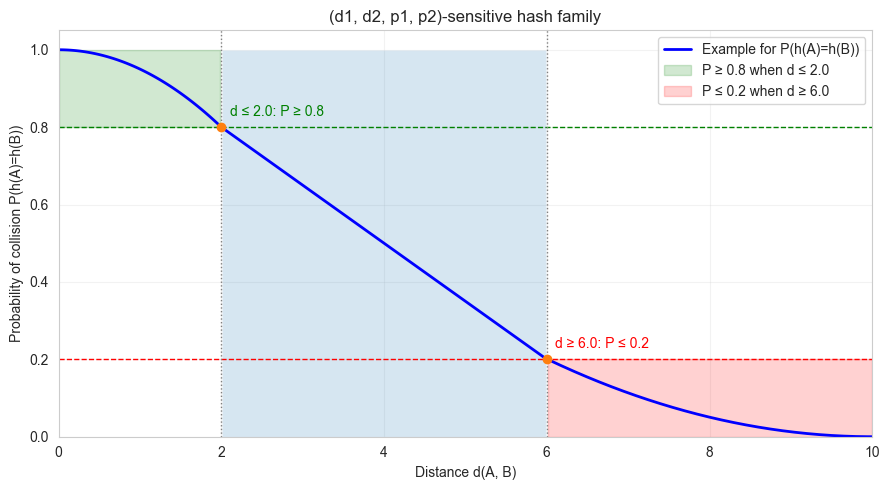

In [7]:
from datamining.plots.lsh import plot_sensitivity_lsh

plot_sensitivity_lsh()

## False-positive rates

Given a locality-sensitive function from a family of hash functions with defined sensitivity, we can construct composite hash functions by combining them. An effective method is to compute multiple such functions in sequence, analogous to the process used for minhash signatures.

Now instead of thinking of such a minhash signature of length $k$ -- calculated based on $k$ independent permutation of the characteristic matrix -- let us treat these signatures as $b$ independent bands, each consisting of $r$ minhash values, hence $k = rb$. 

A sensible way to combine the $k$ independent minhash values could be as follows: investigate every band of minhash values and align two objects into the same bucket if there exists at least one band of minhash values over which they are identical to each other for all the $r$ rows of a band. 

## AND-OR amplification

The AND-OR amplification is a technique used to improve the probability gap between similar and dissimilar items, making LSH more effective for approximate nearest neighbor search.

Suppose we have an LSH family $H$ such that:

$$
\Pr[h(x) = h(y)] =
\begin{cases} 
\ge p_1 & \text{if $x$ and $y$ are "close"} \\
\le p_2 & \text{if $x$ and $y$ are "far"}
\end{cases}
$$

**AND Amplification**

Goal: Reduce false positives (distant points colliding).

Pick $r$ hash functions $h_1,h_2,\dots,h_r$ independently from $H$.
Construct a new combined hash function:
$$
g(x)=(h_1(x),h_2(x),\dots,h_r(x)).
$$

Collision occurs only if all $r$ hashes are equal (AND condition).

**Probability:**

$$
\Pr[g(x) = g(y)] =
\begin{cases} 
\ge p_1^r & \text{for close points} \\
\le p_2^r & \text{for far points}
\end{cases}
$$

**OR Amplification**

**Goal:** Reduce false negatives (missed nearby points).  

- Create **$b$ independent AND-hashes** $(g_1, g_2, \dots, g_b)$.  
- Consider a collision if **any** of the $b$ (OR condition).  

**Probability:**

$$
\Pr[\text{collision in any of the b bands}] =
\begin{cases} 
\ge 1 - (1 - p_1)^b & \text{for close points} \\
\le 1 - (1 - p_2)^b & \text{for far points}
\end{cases}
$$

OR amplification increases collisions for close points, reducing false negatives.

**AND-OR Amplification**

- **AND step ($r$ hashes)** → reduces collisions for far points (false positives).  
- **OR step ($b$ groups of $r$ hashes)** → increases collisions for close points (reduces false negatives).

$$
\Pr[\text{collision in any of the b bands}] =
\begin{cases} 
\ge 1 - (1 - p_1^r)^b & \text{for close points} \\
\le 1 - (1 - p_2^r)^b & \text{for far points}
\end{cases}
$$

By carefully choosing `r` and `b`, we can **amplify the gap** between probabilities for close and far points.

In [ ]:
from datamining.plots.lsh import plot_bands_and_rows

@interact(
    r=widgets.IntSlider(min=1, max=10, step=1, value=3),
    b=widgets.IntSlider(min=1, max=10, step=1, value=5),
)
def _interact(r, b):
    plot_bands_and_rows(r, b)

In [ ]:
class MinHashLSHWithBands:
    def __init__(self, b, r, perm_size, num_inp, seed=42):
        np.random.seed(seed)
        self.b = b
        self.r = r
        self.num_signitures = r * b
        self.pi = np.array([
            np.random.permutation(perm_size)
            for _ in range(self.num_signitures)
        ])
        self.m = np.full((num_signitures, num_inp), fill_value=np.inf)
        self.C = None
        self.buckets = {i: {} for i in range(b)}

    def make_signitures(self, C):
        m = np.full((self.num_signitures, C.shape[1]), fill_value=np.inf)
        # TODO calculate minhash signiture considering input C, rows are films (features) and columns are users
        return m

    def fill_buckets(self, C):
        self.C = C

        self.m = self.make_signitures(C)
        # TODO lets modify it so it can handle bands
        
        for i in range(self.m.shape[1]):
            signiture = self.m[:, i].astype(int).tolist()
            signiture = ",".join([str(x) for x in signiture])
            if signiture not in self.buckets:
                self.buckets[signiture] = []
            self.buckets[signiture].append(i)

    def retrieve_similar(self, C):
        m = self.make_signitures(C)
        # TODO lets modify it so it can handle bands

        ids = []
        for i in range(m.shape[1]):
            signiture = m[:, i].astype(int).tolist()
            signiture = ",".join([str(x) for x in signiture])
            ids.append(self.buckets[signiture])
        return ids

    def jaccard_similarity_input(self):
        X = self.C
        # Intersection: dot product
        intersection = X @ X.T
        
        # Row sums for union calculation
        row_sums = X.sum(axis=1)
        
        # Union = sum(a) + sum(b) - intersection
        union = row_sums[:, None] + row_sums[None, :] - intersection
        
        # Avoid divide-by-zero
        sim = intersection / np.where(union == 0, 1, union)
        return sim
        
    def jaccard_similarity_signiture(self):
        J = np.zeros((self.m.shape[0], self.m.shape[0]))

        for i in range(self.m.shape[0]):
            for j in range(self.m.shape[0]):
                J[i, j] = np.mean(m[:, i] == m[:, j])
        return J

In [ ]:
minhash = MinHashLSHWithBands(10, 3, C.shape[0], C.shape[1])
minhash.fill_buckets(C)
minhash.buckets

In [ ]:
id_ = 7
minhash.retrieve_similar(C[:, id_:id_+1])

## Disallowing False-positives

### Length-based filtering

We can (over)estimate the true Jaccard similarity for any pair of sets of cardinalities $m$ and $n$ with $m \leq n$ by taking the fraction $\frac{m}{n}$. This is true as even if the smaller set is a proper subset of the larger set, the size of their intersection equals the number of elements in the smaller set $(m)$, whereas the cardinality of their intersection would equal the size of the larger set $(n)$. Now assuming that $\frac{m}{n}$ is below some predefined threshold $S$, it is pointless to actually investigate the true Jaccard similarity as it is also definitely below $S$.

In [ ]:
class MinHashLSHWithBandsLF:
    def __init__(self, b, r, perm_size, num_inp, seed=42):
        np.random.seed(seed)
        self.b = b
        self.r = r
        self.num_signitures = r * b
        self.pi = np.array([
            np.random.permutation(perm_size)
            for _ in range(self.num_signitures)
        ])
        self.m = np.full((num_signitures, num_inp), fill_value=np.inf)
        self.C = None
        self.buckets = {i: {} for i in range(b)}
        self.lengths = None

    def make_signitures(self, C):
        m = np.full((self.num_signitures, C.shape[1]), fill_value=np.inf)
        for i in range(C.shape[0]):
            for k in range(self.num_signitures):
                virtual_row_index = self.pi[k][i]
                for j in range(C.shape[1]):
                    if C[i, j] == 1:
                        m[k, j] = min(m[k, j], virtual_row_index)
        return m


    def fill_buckets(self, C):
        self.C = C

        self.m = self.make_signitures(C)
        # TODO lets modify it so it can handle bands and length based filtering
        
        for i in range(self.m.shape[1]):
            signiture = self.m[:, i].astype(int).tolist()
            signiture = ",".join([str(x) for x in signiture])
            if signiture not in self.buckets:
                self.buckets[signiture] = []
            self.buckets[signiture].append(i)

    def retrieve_similar(self, C):
        m = self.make_signitures(C)
        # TODO lets modify it so it can handle bands and length based filtering

        ids = []
        for i in range(m.shape[1]):
            signiture = m[:, i].astype(int).tolist()
            signiture = ",".join([str(x) for x in signiture])
            ids.append(self.buckets[signiture])
        return ids

    def jaccard_similarity_input(self):
        X = self.C
        # Intersection: dot product
        intersection = X @ X.T
        
        # Row sums for union calculation
        row_sums = X.sum(axis=1)
        
        # Union = sum(a) + sum(b) - intersection
        union = row_sums[:, None] + row_sums[None, :] - intersection
        
        # Avoid divide-by-zero
        sim = intersection / np.where(union == 0, 1, union)
        return sim
        
    def jaccard_similarity_signiture(self):
        J = np.zeros((self.m.shape[0], self.m.shape[0]))

        for i in range(self.m.shape[0]):
            for j in range(self.m.shape[0]):
                J[i, j] = np.mean(m[:, i] == m[:, j])
        return J

In [ ]:
minhash = MinHashLSHWithBandsLF(10, 3, C.shape[0], C.shape[1])
minhash.fill_buckets(C)
minhash.buckets

In [ ]:
id_ = 7
minhash.retrieve_similar(C[:, id_:id_+1], 0.7)

### Bloom filters

Imagine you are designing a web crawler. You want to know if a URL has already been visited.
A Python set would work, but it might use gigabytes of memory for billions of URLs.
**A Bloom filter can answer: “Have we seen this before?”** using much less space, at the cost of a small error rate.

A Bloom filter consists of a bit array of length $m$ (all zeros initially), and $k$ independent hash functions.

__To insert an item__:
- Hash it with each of the $k$ functions.
- Take each hash value modulo $m$ → get positions in the bit array.
- Set those bits to 1.

__To check if an item is in the set__:
- Hash it with the same $k$ functions.
- Check those bit positions.
  - If any bit is 0, the item is definitely not in the set.
  - If all bits are 1, the item is probably in the set.


Because different items can map to the same bits, __Bloom filters may return false positives but no false negatives__.
The false positive probability is approximately:
$$
p = \left(1 - e^{-kn/m}\right)^k,
$$
where $n$ is the number of inserted items, $m$ is the size of bit array, and $k$ is the number of hash functions.

If expected number of elements $n$ is known and desired false positive probability is $p$ then the size of bit array $m$ can be calculated as:
$$
m = - \frac{n\ln p}{(\ln 2)^2}
$$
We can also derive the optimal $k$ for given $m$ and $n$:
$$
k = \frac{m}{n} \ln 2
$$

[Image source](https://systemdesign.one/bloom-filters-explained/)

<img src="https://github.com/ficstamas/data-mining/blob/master/notebooks/images/add-item-bloom-filter.webp?raw=true" width=800>

In [ ]:
import hashlib 

m = 5 # bit array size 
k = 3 # number of hash functions 
bit_array = [0] * m

def get_hashes(item, m, k): 
    """
    item: item to hash
    m: size of bit_array
    k: number of hash functions

    Returns K hash values within a list
    """
    h1 = int(hashlib.sha256(item.encode()).hexdigest(), 16) 
    h2 = int(hashlib.md5(item.encode()).hexdigest(), 16) 
    return [(h1 + i*h2) % m for i in range(k)] 

def add(item): 
    pass  # todo finish the function, add values to bit_array

def query(item): 
    pass  # TODO finish the function, check if an item is present or not

In [ ]:
add("apple") 
print(bit_array) 
print("apple?", query("apple")) 
print("banana?", query("banana"))
print("banana?", query("orange"))

In [ ]:
# what is the associated false positive probability


# Hyperplane (Cosine) LSH

Hyperplane Locality-Sensitive Hashing (LSH) is a method for approximate nearest neighbor search, assuming **cosine similarity**.

**How it works:**

- The key idea is to use random hyperplanes through the origin to partition space.
- Given a random vector $r\sim\mathcal{N}(0,I_d)$ (the normal distribution in $\mathbb{R}^d$), you define a hash function:

$$
h_r(x) = 
\begin{cases}
1 & \text{if } r \cdot x \geq 0 \\
0 & \text{otherwise}
\end{cases}
$$
This means:
- If $x$ lies on one side of the hyperplane, it hashes to 1.
- If it lies on the other side, it hashes to 0.

By repeating with multiple idependent random hyperplanes, each vector is mapped to a binary code.

In [ ]:
from datamining.plots.lsh_hyperplane import plot_hyperplane_example

@interact(
    step=widgets.ToggleButtons(
        options=[1, 2, 3, 4, 5, 6],
        description='Step:',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        # tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
        # icons=['check'] * 3
    ),
    angle=widgets.IntSlider(min=1, max=359, step=1, value=220),
)
def _interact(step, angle):
    plot_hyperplane_example(step, angle)

## Connection to Cosine Similarity
The probability that two vectors $x$ and $y$ have the same hash under a random hyperplane depends only on the **angle** $\mathbf{\Theta}$ between them:

$$
\Pr[h_r(x) = h_r(y)] = 1 - \frac{\theta(x, y)}{\pi} = \frac{180-rad2deg(\theta(x, y))}{180}
$$

## Intuition
- If $x$ and $y$ are very similar (high cosine similarity → small angle), they are more likely to fall on the same side of any random hyperplane.  
- If $x$ and $y$ are orthogonal $(\cos = 0, \theta = \pi/2)$, the probability of collision is 0.5.  
- If they point in opposite directions $(\cos = -1, \theta = \pi)$, the probability is 0.  

In [ ]:
vectors = np.array([[-0.1, 0.5], [0.3, 0.2]])  # vectors A and B from earlier plot/figure
A, B = vectors[0], vectors[1]

true_angle = np.inner(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
true_angle = np.arccos(true_angle)
np.degrees(true_angle)

In [ ]:
num_planes = 300
hash_functions = np.random.randn(num_planes, 2)
hash_functions.shape

In [ ]:
projections = vectors @ hash_functions.T
hash_code = (projections >= 0).astype(int)
hash_code

In [ ]:
def approx_sketch(sketch_A, sketch_B):
    k = len(sketch_A)
    matching_bits = np.sum(sketch_A == sketch_B)
    p_hat = matching_bits / k
    theta_hat = np.pi * (1 - p_hat)
    return np.degrees(theta_hat)


x = np.arange(0, num_planes)
y = []

for i in range(1, num_planes+1):
    sketch_A, sketch_B = hash_code[0][:i], hash_code[1][:i]
    y.append(approx_sketch(sketch_A, sketch_B))


plt.plot(x, y, label="Approximated Angle")
plt.hlines(np.degrees(true_angle), 0, num_planes, color="red", label="True Angle")
plt.legend()

## In practice
- Load and preprocess data
- Initialize hash functions and tables
- Hash the set of values
- Retrieve documents

### Data loading

In [ ]:
from sklearn.datasets import fetch_20newsgroups

# Load training subset (you can also load 'test')
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_train_y = newsgroups_train.target
id2label = newsgroups_train.target_names

print("Number of documents:", len(newsgroups_train.data))
print("Categories:", newsgroups_train.target_names[:5], "...")

# Example document
print("\nSample document:\n")
print(newsgroups_train.data[0])

In [ ]:
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
newsgroups_test_y = newsgroups_test.target

### Preprocessing

TF-IDF (term frequency-inverse document frequency) expresses how much a word is important to a document in a corpus (collection of documents). The basic idea behind TF-IDF is to represent each document or piece of text as a numerical vector, with each element in the vector representing a different word or term in the text. The value of each element is calculated based on the frequency of the term in the document (term frequency) and the inverse of the frequency of the term in all documents (inverse document frequency).

$$\text{tf-idf}(t,d)=\text{tf}(t,d)\cdot \text{idf}(t)$$

The term frequency measures how often a particular word appears in a document, with the assumption that more frequent terms are more important for the meaning of the document. 

$$\text{tf}(t,d)=\frac{f_{t,d}}{\sum_{t'\in d}f_{t',d}},$$

where $f_{t,d}$ represent the number of times $t$ occured in $d$, and $\sum_{t'\in d}f_{t',d}$ is just the total number of term  in document $d$.

On the other hand, the inverse document frequency measures how unique a term is across all documents, with the assumption that terms that appear in many documents are less important for the meaning of a single document. For example, in english the words "the", "a" or "is" are not that important, but may occur many times in a single document.

$$\text{idf}(t)=\log{\frac{|D|}{|\{d\in D : t \in d\}|}},$$
where $|D|$ is the number of documents, and $|\{d\in D : t \in d\}|$ is the number of documents where the term $t$ appears.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=20_000)
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.fit_transform(newsgroups_test.data)

### Implementation

In [ ]:
class HyperplaneLSH:
    def __init__(self, num_tables, num_hashes, input_dim=5000, seed=42):
        np.random.seed(seed)
        self.num_tables = num_tables
        self.num_hashes = num_hashes
        num_planes = num_tables * num_hashes
        self.hash_functions = np.random.randn(num_planes, input_dim)
        self.buckets = {i: {j: set() for j in range(2**num_hashes)} for i in range(num_tables)}
        self.data = None
        self.labels = None
    
    def hash(self, x):
        """
        x -> vectorized tfidf representation
        """
        # TODO implement hashing
        pass

    def hash_value_to_bucket(self, hash_values):
        """
        hash_values -> matrix of binary hash values 
        """
        # TODO implement a function which convert binary hashed vectors to integers, i.e., [1, 0, 1, 0] -> [5]
        # take the tables into consideration
        pass
    
    def fill_buckets(self, x, data, labels):
        """
        x -> vectorized tfidf representation
        data -> list of documents as strings
        labels -> list of labels
        """
        self.data = data
        self.labels = labels
        hash_values = self.hash(x)
        hash_values = hash_values.reshape(-1, self.num_tables, self.num_hashes)
        bucket_ids = self.hash_value_to_bucket(hash_values)
        for i in range(x.shape[0]):
            for t in range(self.num_tables):
                self.buckets[t][bucket_ids[i][t]].add(i)

    def retrieve_document(self, x):
        """
        x -> vectorized tfidf representation
        """
        hash_values = self.hash(x)
        hash_values = hash_values.reshape(-1, self.num_tables, self.num_hashes)
        bucket_ids = self.hash_value_to_bucket(hash_values)
        retrieved_ids = set()
        for t in range(self.num_tables):
            retrieved_ids |= self.buckets[t][bucket_ids[0][t]]
        retrieved_ids = list(retrieved_ids)
        results = {"documents": [], "labels": []}
        for doc_id in retrieved_ids:
            results["documents"].append(self.data[doc_id])
            results["labels"].append(self.labels[doc_id])
        return results

In [ ]:
lsh = HyperplaneLSH(8, 16, X_train.shape[-1])
lsh.fill_buckets(X_train, newsgroups_train.data, newsgroups_train_y.astype(int))

### Finding similar documents

In [ ]:
id_ = 11
print(f"{id2label[newsgroups_test_y[id_]]}: {newsgroups_test.data[id_]}\n------------------------------------------------------------------------------------------\n")
ret = lsh.retrieve_document(X_test[id_])
for i in range(len(ret["documents"])):
    print(f"{id2label[ret['labels'][i]]}: {ret['documents'][i]}\n------------------------------------------------------------------------------------------\n")

In [ ]:
id_ = 11
print(f"{id2label[newsgroups_test_y[id_]]}:\n------------------------------------------------------------------------------------------\n")
ret = lsh.retrieve_document(X_test[id_])
for i in range(len(ret["documents"])):
    print(f"{id2label[ret['labels'][i]]}:\n------------------------------------------------------------------------------------------\n")